# Some Experiments
used for some shit

## Imports

In [18]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [19]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

# own classes
from utilities import load_sequential_time_series, train_test_split, extract_features_and_targets_reg, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor
from data_generation.algorithmic.brownian_motion import brownian_motion

In [20]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

## Brownian Motion

In [21]:
traffic_le = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded.csv")

In [22]:
traffic_le.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
0,444,289.40,0.0,0.0,1,7,1,0,24,0,0
1,347,289.19,0.0,0.0,1,7,2,0,24,0,0
2,356,288.74,0.3,0.0,1,7,3,6,12,0,0
3,936,288.07,0.0,0.0,1,7,4,0,24,0,0
4,2886,287.87,0.0,0.0,1,7,5,0,24,0,0


In [23]:
traffic_le.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795,6.635509,11.500403,2.211006,16.516537,0.286205,0.001298
std,1971.53206,12.367361,0.678185,0.008298,39.316195,3.343684,6.922094,2.719176,8.206819,0.451994,0.036001
min,0.00000,243.390000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000,4.000000,6.000000,0.000000,12.000000,0.000000,0.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000,7.000000,12.000000,1.000000,18.000000,0.000000,0.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000,9.000000,17.500000,5.000000,24.000000,1.000000,0.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000,12.000000,23.000000,9.000000,33.000000,1.000000,1.000000


In [24]:
traffic_syn = brownian_motion(traffic_le, 
                              features=['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all'],
                              other_columns=['weather_main', 'weather_description'])

Augmenting the following columns with brownian motion: ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']...


In [25]:
traffic_syn.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
0,444.000000,289.400000,0.000000,0.000000,1.000000,7,1,0,1,0,0
1,1832.975393,288.475937,0.000000,0.002591,35.561817,7,2,9,12,0,0
2,2602.394983,288.757248,0.341790,0.004084,3.531648,7,3,0,24,0,0
3,3427.898575,288.870013,0.740969,0.005319,48.973775,7,4,1,24,0,0
4,2320.583951,287.775331,0.598242,0.000000,15.125652,7,5,1,6,0,0


Text(0.5, 0, 'Time')

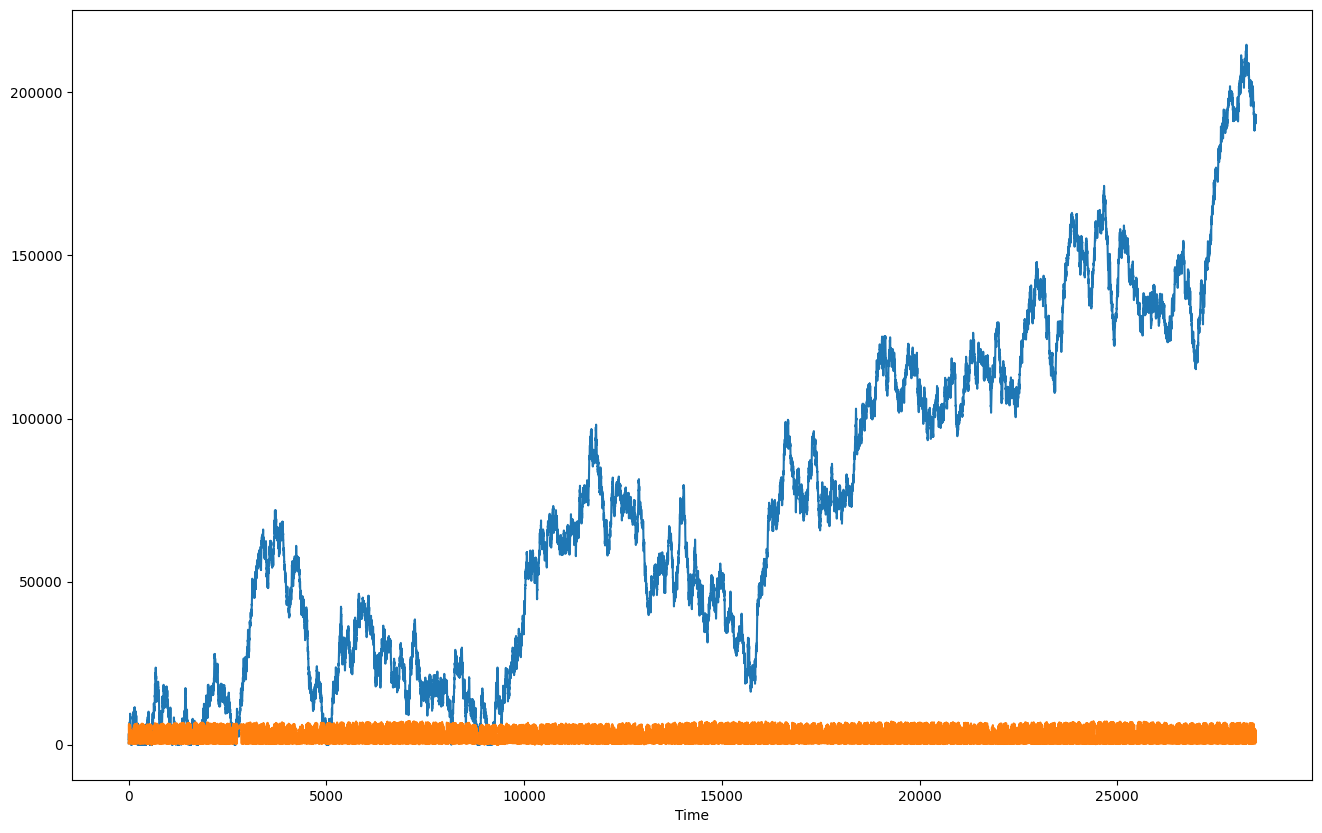

In [26]:
plt.figure(figsize=(16, 10))
plt.plot(traffic_syn['traffic_volume'], label='Synthetic Traffic Volume')
plt.plot(traffic_le['traffic_volume'], label='Real Traffic Volume')
plt.xlabel('Time')

In [27]:
traffic_syn.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
count,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000
mean,73437.637439,482.213963,55.352933,0.875575,2539.526534,6.635509,11.500403,2.211006,16.516537,0.286205,0.001298
std,51911.949534,66.970254,29.773770,0.355206,2197.008775,3.343684,6.922094,2.719176,8.206819,0.451994,0.036001
min,0.000000,281.500607,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26266.501971,460.543576,29.133164,0.593254,464.313974,4.000000,6.000000,0.000000,12.000000,0.000000,0.000000
50%,66344.997365,494.405382,58.365844,0.914051,1753.223673,7.000000,12.000000,1.000000,18.000000,0.000000,0.000000
75%,114826.085395,526.464493,80.238182,1.087635,4821.275915,9.000000,17.500000,5.000000,24.000000,1.000000,0.000000
max,214619.093827,615.578586,122.627686,1.620264,6469.496143,12.000000,23.000000,9.000000,33.000000,1.000000,1.000000


In [28]:
traffic_le.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795,6.635509,11.500403,2.211006,16.516537,0.286205,0.001298
std,1971.53206,12.367361,0.678185,0.008298,39.316195,3.343684,6.922094,2.719176,8.206819,0.451994,0.036001
min,0.00000,243.390000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000,4.000000,6.000000,0.000000,12.000000,0.000000,0.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000,7.000000,12.000000,1.000000,18.000000,0.000000,0.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000,9.000000,17.500000,5.000000,24.000000,1.000000,0.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000,12.000000,23.000000,9.000000,33.000000,1.000000,1.000000


In [29]:
traffic_syn.to_csv(SYNTHETIC_DATA_FOLDER / "mitv_brownian_motion.csv", index=False)

## Rescale timeGAN data

In [36]:
timegan_data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / "mitv_28499_12_11_lstm_no_replace.csv", shape=(28499, 12, 11))
ori_data = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded.csv").to_numpy()

In [37]:
timegan_data.shape

(28499, 12, 11)

In [38]:
re_scaler = Scaler(ori_data, no_features_to_scale=9)

In [39]:
scaled_ori = re_scaler.scale_data(ori_data)

In [40]:
rescaled_timegan = re_scaler.inverse_scale_complete_dataset(timegan_data, data_is_split=True)

In [41]:
rescaled_timegan.shape

(28499, 12, 11)

In [42]:
rescaled_timegan[0]

array([[5.30089910e+03, 2.84405577e+02, 5.27715683e-02, 3.45219076e-04,
        9.42333698e+01, 4.51686984e+00, 1.17646220e+01, 7.08426118e+00,
        1.91338685e+01, 1.32083893e-04, 1.60366297e-04],
       [4.25144877e+03, 2.90038766e+02, 3.70652676e-02, 4.96405363e-05,
        9.04867768e+01, 7.10228175e+00, 1.24407958e+01, 6.47396529e+00,
        1.68986621e+01, 5.52833080e-05, 4.91142273e-05],
       [6.86127847e+03, 2.87306066e+02, 5.82540035e-03, 1.64151192e-06,
        4.37153280e+00, 6.04412481e+00, 1.34172009e+01, 3.20020258e-01,
        2.31942127e+01, 1.00135803e-05, 4.75615263e-04],
       [1.70543032e+03, 2.87639601e+02, 4.03296947e-03, 1.51383877e-05,
        6.75294042e+01, 7.03090626e+00, 1.51375052e+01, 3.01789391e+00,
        6.34542373e+00, 5.65648079e-05, 4.42862511e-05],
       [7.84218433e+02, 2.98345615e+02, 2.26557255e-04, 1.38312578e-06,
        6.45267963e-01, 6.52551597e+00, 3.23318779e-01, 4.06031191e-01,
        2.02836431e+01, 3.74913216e-05, 5.63529134e-

In [43]:
timegan_data[0]

array([[7.28145480e-01, 6.15110636e-01, 1.25646591e-03, 6.76900148e-04,
        9.42333698e-01, 3.19715440e-01, 5.11505306e-01, 7.87140131e-01,
        5.79814196e-01, 1.32083893e-04, 1.60366297e-04],
       [5.83990216e-01, 6.99591577e-01, 8.82506371e-04, 9.73343849e-05,
        9.04867768e-01, 5.54752886e-01, 5.40904164e-01, 7.19329476e-01,
        5.12080669e-01, 5.52833080e-05, 4.91142273e-05],
       [9.42483306e-01, 6.58609271e-01, 1.38700008e-04, 3.21865082e-06,
        4.37153280e-02, 4.58556801e-01, 5.83356559e-01, 3.55578065e-02,
        7.02854931e-01, 1.00135803e-05, 4.75615263e-04],
       [2.34262407e-01, 6.63611293e-01, 9.60230827e-05, 2.96831131e-05,
        6.75294042e-01, 5.48264205e-01, 6.58152401e-01, 3.35321546e-01,
        1.92285568e-01, 5.65648079e-05, 4.42862511e-05],
       [1.07722312e-01, 8.24169397e-01, 5.39422035e-06, 2.71201134e-06,
        6.45267963e-03, 5.02319634e-01, 1.40573382e-02, 4.51145768e-02,
        6.14655852e-01, 3.74913216e-05, 5.63529134e-

In [48]:
asdf = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / "mitv_28499_12_11_lstm_no_replace_unscaled.csv", shape=(28499, 12, 11))